In [ ]:
import numpy as np

# Assumptions
# - 1 unique key per job
# - pattern is Linear Ops -> PBSs and MulAdd
# - same param set for all jobs (because mixing parameters sets makes no sense, at worst you get the lowest security level) --> key sizes are known in advance --> key loading times are known in advance
#   if relevant: use the parameterset with the 2 bit message space + 2 bit carry from ZAMA
# - static scheduler --> no need to schedule Noise management (PBS are inserted already as needed, noise management PBS are uncommon in TFHE anyway), no interrupts
# - PBS engines cannot share in-between results --> a job must be seperateable into sub-jobs for multiple engines to increase performance

# info
# use typical tfhe patterns for benchmarking: Schoolbook addition/Multiplication/Comparison Patterns
# PBS = PBS + keyswitch --> therefore with "key" we denote BSK & KSK together

# TODO and problem chain:
# - press job-DAGs into batches - DONE, now the outside only sees jobs with different runtimes
# - need to assign a given set of jobs to multiple PBS engines, respecting multi-tenant fairness, avoiding key loading and so on - TODO
# - need to consider two types of engines: PBS and MulAdd - TODO

key_freespace_indicator = -1
batch_freespace_indicator = -1
global_tic_cnt = 0 # incremented by scheduler

class TFHE_sub_job:
    # a sub_job is a part of a job that leads to an in-between result that other jobs might wait for
    def __init__(self, parallelizeable_calls_array, key_idx):
        # parallelizeable_calls_array for each "step" of the job computation, this array shows how many PBS calls can de done
        # indepentendly and therefore in parallel
        self.key_idx = key_idx
        self.parallelizeable_calls_array = np.array(parallelizeable_calls_array)
        self.parall_array_temp = np.array(parallelizeable_calls_array)
        self.parall_arr_idx = 0
        self.maketime = -1
        self.age = 0
        self.done = False
        self.best_maketime_to_completion = -1
    
    def get_best_maketime(self, batchsize): # in batches, since 1 batch = 1 time unit, batches are a time unit
        return sum(np.ceil(self.parallelizeable_calls_array/batchsize))
    
    def get_best_maketime_to_completion(self, batchsize): # in batches, since 1 batch = 1 time unit, batches are a time unit
        return sum(np.ceil(self.parall_array_temp/batchsize))
    
    def inc_age(self):
        # scheduler must increase the age until the job is done
        if sum(self.parall_array_temp) != 0:
            self.age += 1

    def serve_pbs(self, cnt):
        cnts_left = self.parall_array_temp[self.parall_arr_idx]
        unused_cnts = 0
        if cnts_left > cnt:
            self.parall_array_temp[self.parall_arr_idx] -= cnt
        else:
            self.parall_array_temp[self.parall_arr_idx] = 0
            unused_cnts = cnt - cnts_left
            if self.parall_arr_idx+1 < len(self.parallelizeable_calls_array):
                self.parall_arr_idx += 1
            else:
                # list empty = job done
                self.done=True
                self.maketime = self.age
                # sanity check
                checksum = sum(self.parall_array_temp)
                if checksum != 0:
                    print("Error: job finished with " + str(checksum) + " leftover PBS calls - this is not supposed to happen, something went wrong")
        return unused_cnts

class PBS_engine:
    def __init__(self, pbs_per_s, batchsize, key_loading_time, max_num_keys):
        self.speed = pbs_per_s
        self.batchsize = batchsize
        self.key_loading_time = key_loading_time # in batches per second
        self.max_num_keys = max_num_keys

        self.key_storage = np.ones(max_num_keys)*key_freespace_indicator # this array stores the indices of the keys that are present on the device
        self.batch = np.ones(batchsize)*batch_freespace_indicator
        self.wasted_batchslots = 0
        self.new_key_storage = np.ones(max_num_keys)
        self.key_loading_cooldown = 0

    def run(self):
        self.wasted_batchslots += len(np.argwhere(self.batch==batch_freespace_indicator))
        # empty batch
        self.batch = np.ones(self.batchsize)*batch_freespace_indicator
        # update key storage
        if self.key_loading_cooldown > 0:
            self.key_loading_cooldown -= 1
        else:
            self.key_storage = self.new_key_storage
        # TODO: fill batch anew

    def add_to_batch(self, num_ciphertexts, key_idx):
        # only allow to fill batch with ciphertexts that we have the keys for
        if len(np.argwhere(self.key_storage==key_idx)) > 0:
            # is there still space in the batch?
            indices = np.argwhere(self.batch==batch_freespace_indicator)
            if len(indices) > num_ciphertexts:
                for i in range(num_ciphertexts):
                    self.key_storage[indices[i]] = key_idx
            else:
                print("Error: could not add to batch ciphertext of key " + key_idx + " - reason: batch capacity insufficient")
        else:
            print("Error: could not add batch with key " + key_idx + " - reason: key not present - load the key first")

    def unload_key(self, key_idx):
        indice = np.argwhere(self.key_storage==key_idx)
        # we expect the key to be present on the device only once
        if len(indice) > 0:
            self.new_key_storage[indice[0]]=key_freespace_indicator
        else:
            # this is unexpected
            print("Warning: could not unload key " + key_idx + " - reason: key not present")

    def load_key(self, key_idx):
        # are we already loading a key?
        if self.key_loading_cooldown == 0:
            # is there still space?
            indices = np.argwhere(self.key_storage==key_freespace_indicator)
            if len(indices) > 0:
                # is the key already present on the device?
                if len(np.argwhere(self.key_storage==key_idx)) > 0:
                    print("Warning: key " + key_idx + " - is already present, did not load again")
                else:
                    self.new_key_storage[indices[0]] = key_idx
                    self.key_loading_cooldown = self.key_loading_time
            else:
                # need to overwrite some key
                # yes, could do complicated logic here but we trust that after a job is done the unloading function is called
                print("Error: could not load key " + key_idx + " - reason: key storage full - unload a key first")
        else:
                print("Error: could not load key " + key_idx + " - reason: a key is already being loaded")

# scheduler
# given a list of sub_jobs, sorted by priority metric, and a PBS_engine, give jobs to the engine
# strategy: focus jobs for better latency in a certain priority, only use other jobs to fill up leftover spaces

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import itertools

# we use the coffman-graham approach to press each job into as few batches as possible given a batchsize
# because each job has a unique key and therefore we cannot mix jobs in batches
# we use a parent-child-structure to model the DAG schedule (DAG --> directed ascyclic graph = no circular dependencies)
# TODO: key loading, multiple jobs

class Node:
    def __init__(self, id: int, parents_list: list):
        self.id: int = id
        self.parents: list[Node] = parents_list # parents are other nodes
        self.posV = 0
        #self.posV_offset_to_parent = 1 # vertical offset to leftmost parent
        self.posH = 0
        self.posH_offset_to_parent = 0 # horizontal offset to leftmost parent
        self.spaceH_required = 1
        self.max_distance_to_end_node = -1
        self.rootNode = (len(self.parents) == 0)
        self.is_executed = self.rootNode # root node is always executed
        self.children: list[Node]=[]
        max_depth = 0
        for parent in self.parents:
            parent.add_child(self) # add yourself as a child of your parents
            max_depth = max(max_depth, parent.depth)
        self.depth = max_depth+1 # this node is a child of its parents and therefore one deeper

    def __eq__(self, other): # for set operations
        return self.id==other.id
    
    def __hash__(self): # for set operations
        return hash(self.id)
    
    def __gt__(self, other): # for sorting
        return self.max_distance_to_end_node > other.max_distance_to_end_node
    
    def deregister(self): # call this before removing this node from the graph
        # remove your reference from your children and parents
        for child in self.children:
            child.parents.remove(self)
        for parent in self.parents:
            parent.children.remove(self)

    def can_execute(self):
        # you can execute if all your parents were executed
        # and you have not already been executed
        execute_ready = False
        if not self.is_executed:
            execute_ready = True
            for parent in self.parents:
                execute_ready = execute_ready and parent.is_executed
        return execute_ready
    
    def execute(self):
        self.is_executed = True

    def update_max_distance_to_endnode(self):
        # check your children's distance to the end node
        # if you have no children, you are the end node
        no_update = False
        if len(self.children) > 0:
            max_val = 0
            for child in self.children:
                # check if all your children already have values. If not, the last child will call you
                if child.max_distance_to_end_node == -1:
                    # you don't have the values of all your children, so don't update now
                    no_update = True
                    break
                max_val = max(child.max_distance_to_end_node, max_val)
        else:
            max_val = -1
        if not no_update:
            self.max_distance_to_end_node = max_val + 1
            # propagate this call to your parents
            for parent in self.parents:
                parent.update_max_distance_to_endnode()
                
    def add_child(self, child):
        self.children.append(child)

    ###### all these methods are just for visulaization ######
    def update_relativeH(self):
        # parent checks all his childrens width, gives the children positions relative to itself, then updates its own width
        # negative change to move left, positive to move right
        previous_children_hspace_sum = 0
        for child in self.children:
            if self.id == child.parents[0].id: # check if you are root parent of the child
                child.posH_offset_to_parent = previous_children_hspace_sum
                previous_children_hspace_sum += child.spaceH_required
        self.spaceH_required = max(previous_children_hspace_sum, self.spaceH_required) # remember the ones that are not root parents for any of their children
        # hand the call down
        for child in self.children:
            child.update_relativeH()
    
    def get_flexibilities_to_parents(self):
        # find parent with the least vertical distance to you, that is your upward flexibility
        if self.rootNode:
            min_parent_distance = 1
        else:
            min_parent_distance = self.posV- self.parents[0].posV
        for idx, parent in enumerate(self.parents):
            min_parent_distance = min(min_parent_distance, self.posV- parent.posV)
        return min_parent_distance
    
    def updateH(self): # horizontal update
        # use your relative position to your parent to get an absolut position
        if not self.rootNode: # no position change for root node
            # check parent position and update accordingly
            self.posH = self.parents[0].posH + self.posH_offset_to_parent
        for child in self.children:
            child.updateH()
    
    def updateV(self): # vertical update
        # no need for relative position to parent
        if not self.rootNode: # no position change for root node
            # check parent position and update accordingly
            min_parent_distance = self.get_flexibilities_to_parents()
            if min_parent_distance < 1:
                # pos_change: positive for down, negative for up
                pos_change = 1-min_parent_distance
                self.posV+= pos_change
        # update your children
        for child in self.children:
            child.updateV()



In [ ]:
# functions

def view_schedule(node_set):
    G = nx.DiGraph()
    fixed_y = {}
    fixed_x = {}
    edge_list = []
    for node in node_set:
        fixed_y[node.id] = node.posV
        fixed_x[node.id] = node.posH
        for child in node.children:
            edge_list.append((node.id,child.id))
    G.add_edges_from(edge_list)
    pos = {n: np.array([fixed_x[n], -fixed_y[n]]) for n in G.nodes()}
    nx.draw_networkx_nodes(G,pos,node_size=700)
    nx.draw_networkx_labels(G,pos,font_size=20,font_family='sans-serif')
    nx.draw_networkx_edges(G,pos,edgelist=edge_list, width=6)
    plt.show()

def arange_nodes(node_set, start_node): # call this once before view_schedule
    # find out how many parallel lines there are
    max_depth = 0
    for node in node_set:
        max_depth = max(max_depth, node.depth)
    start_node.updateV()
    # we use a lazy method here: update top-down through depth-many iterations
    for layer_idx in range(max_depth):
        start_node.update_relativeH()
    # now that each node knows its relative position, translate it into an absolute position
    start_node.updateH()

def line_remove_elem(line, idx):
    line[idx].deregister()
    line.remove(line[idx])

def get_job_makespan(nodes_set, end_node, batchsize):
    # scheduling logic: determine node execution order via coffman-graham algorithm
    # meaning: execute the nodes that are furthest away from the end node
    num_batches = 0
    end_node.update_max_distance_to_endnode() # computing cascade which gives each node its distance to the end node
    for i in range(len(nodes_set)): # can have at max num_nodes iterations
        possible_nodes = []
        for node in nodes_set:
            if node.can_execute():
                possible_nodes.append(node)
        possible_nodes.sort(reverse=True) # sorts by max_distance_to_end_node, highest first
        nodes_to_execute = possible_nodes[0:batchsize]
        if len(nodes_to_execute) > 0 and nodes_to_execute[0]!=end_node:
            for idx, node in enumerate(nodes_to_execute):
                print("Iteration: " + str(i) + ", executing node " + str(node.id))
                node.execute()
                node.posV = i+1
                #node.posH = idx
        else:
            # done
            num_batches = i
            break
    return num_batches

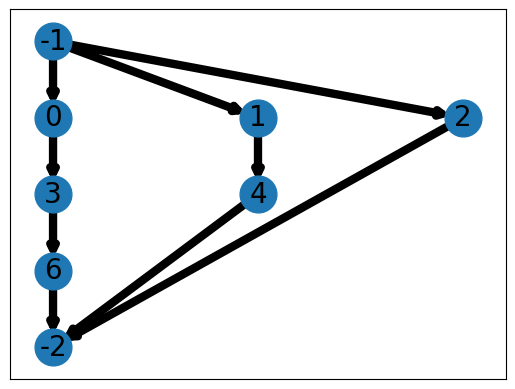

Iteration: 0, executing node 0
Iteration: 0, executing node 1
Iteration: 1, executing node 3
Iteration: 1, executing node 2
Iteration: 2, executing node 4
Iteration: 2, executing node 6


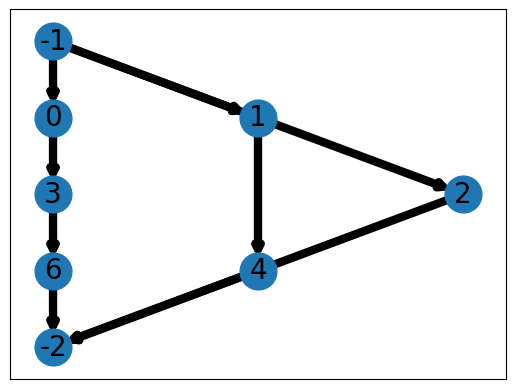

Makespan/batches: 3 Average batch usage: 1.0


In [ ]:
# build an example schedule with root and end node
root_node = Node(-1, [])
list_of_lines = [[root_node],[root_node],[root_node]]
num_line_nodes = 3
for idx, line in enumerate(list_of_lines):
    for i in range(0, num_line_nodes, 1):
        line.append(Node(idx+i*len(list_of_lines), [line[-1]]))
line_remove_elem(list_of_lines[1], -1)
line_remove_elem(list_of_lines[2], -1)
line_remove_elem(list_of_lines[2], -1)
global_node_set = set(itertools.chain(*list_of_lines)) # set gets rid of nodes that occur multiple times
final_node = Node(-2,[list[-1] for list in list_of_lines])
global_node_set.add(final_node)

# visualize it for reference
arange_nodes(global_node_set, root_node)
view_schedule(global_node_set)

batchsize = 2
num_batches = get_job_makespan(global_node_set, final_node, batchsize=batchsize)

# visualize the solution
view_schedule(global_node_set)

# compute performance metrics
num_nodes = len(global_node_set)-2 # root and end nodes do not count
batch_usage = num_nodes/(num_batches*batchsize)
print("Makespan/batches:", num_batches, "Average batch usage:", batch_usage)
